<a href="https://colab.research.google.com/github/Teeboi96/fictional-octo-sporksql/blob/main/IMDB_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
#Import necessary libraries
import sqlite3
import pandas as pd

In [35]:
# Create an in-memory database
conn = sqlite3.connect('imdb_reviews.db')
cursor = conn.cursor()

In [47]:
#Upload .tar.gz IMDb dataset
from google.colab import files
uploaded = files.upload()

In [4]:
#Extract .tar.gz IMDb dataset
import tarfile

# Specify the name of the tar.gz file
tar_file_name = 'aclImdb_v1.tar.gz'

# Open the tar.gz file
with tarfile.open(tar_file_name, 'r:gz') as tar:
    #Extract all files to the current directory
    tar.extractall()

print(f"Extracted {tar_file_name}")

Extracted aclImdb_v1.tar.gz


In [5]:
import os

#List directories in the extracted folder
os.listdir('/content/aclImdb')

['imdb.vocab', 'README', 'test', 'imdbEr.txt', 'train']

In [7]:
#Load review files from 'pos' and 'neg' folders
import glob
def load_reviews_from_folder(folder_path, sentiment):
    files = glob.glob(os.path.join(folder_path, '*.txt'))
    data = []
    for file in files:
      with open(file, 'r', encoding='utf-8') as f:
        content = f.read()
        data.append((content,sentiment))
    return data

#Load reviews
positive_reviews = load_reviews_from_folder('/content/aclImdb/train/pos', 'positive')
negative_reviews = load_reviews_from_folder('/content/aclImdb/train/neg', 'negative')

#Combine and convert to DataFrame
all_reviews = positive_reviews + negative_reviews

import pandas as pd
df = pd.DataFrame(all_reviews, columns=['review', 'statement'])

#Preview the result
display(df.head())

,review,statement
0,Ed Harris's work in this film is up to his usu...,positive
1,"Frailty--8/10--It's non-sensical title and ""Bi...",positive
2,"It was once suggested by Pauline Kael, never a...",positive
3,"A classy offering from Amicus, producer Milton...",positive
4,I bought the DVD of Before Sunset and saw it f...,positive


In [9]:
#Save to SQLite
import sqlite3
conn = sqlite3.connect('imdb_reviews.db')
df.to_sql('reviews', conn, if_exists='replace', index=False)

25000

In [11]:
#Count of Reviews by Statement Type
pd.read_sql_query("SELECT statement,COUNT(*) as total FROM reviews GROUP BY statement", conn)

,statement,total
0,negative,12500
1,positive,12500


In [16]:
#Average Word Count by Statement
pd.read_sql_query("""SELECT statement,AVG(LENGTH(review) -LENGTH(REPLACE(review, ' ', '')) + 1) AS avg_word_count FROM reviews GROUP BY statement""", conn)

,statement,avg_word_count
0,negative,230.85776
1,positive,236.69568


In [17]:
#Find Reviews Containing a Specific Word
pd.read_sql_query("""SELECT statement, review FROM reviews WHERE review LIKE '%excellent%'LIMIT 10""", conn)

,statement,review
0,positive,I recently saw this film and enjoyed it very m...
1,positive,I saw this with few expectations and absolutel...
2,positive,"I'm an admirer of Hal Hartley's films, especia..."
3,positive,I had the opportunity to see this film twice a...
4,positive,I think Dark Angel is great! First season was ...
5,positive,It's very hard to say just what was going on w...
6,positive,In 1954 Marlon Brando was THE hot actor after ...
7,positive,This is the best and most original show seen i...
8,positive,"When it came out, this was pretty much state o..."
9,positive,The film adaptation of James Joyce's Ulysses i...


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_2['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

In [18]:
#Top 10 Longest Reviews by Character Count
pd.read_sql_query("""SELECT statement, LENGTH(review) AS char_count, review FROM reviews ORDER BY char_count DESC LIMIT 10""", conn)

,statement,char_count,review
0,positive,13704,Match 1: Tag Team Table Match Bubba Ray and Sp...
1,positive,10363,**Attention Spoilers**<br /><br />First of all...
2,positive,10321,Titanic directed by James Cameron presents a f...
3,positive,9420,By now you've probably heard a bit about the n...
4,positive,9345,*!!- SPOILERS - !!*<br /><br />Before I begin ...
5,negative,8969,Some have praised _Atlantis:_The_Lost_Empire_ ...
6,negative,8754,Some have praised -Atlantis:-The Lost Empire- ...
7,positive,8180,Warning: Does contain spoilers.<br /><br />Ope...
8,positive,8056,Polish film maker Walerian Borowczyk's La Bête...
9,negative,7761,"*** Warning - this review contains ""plot spoil..."


In [19]:
#Count of Keyword Appearances by Statement
pd.read_sql_query("""SELECT statement, COUNT(*) as total FROM reviews WHERE review LIKE '%love%' GROUP BY statement""", conn)

,statement,total
0,negative,2313
1,positive,4090


In [21]:
#Most common words in positive vs negative reviews
import re

#Split reviews into words
def split_into_words(text):
  return re.findall(r'\b\w+\b', text.lower())

word_list = []

for i, row in df.iterrows():
  words = split_into_words(row['review'])
  for word in words:
    word_list.append((word, row['statement']))

words_df = pd.DataFrame(word_list, columns=['word', 'statement'])
words_df.to_sql('words', conn, if_exists='replace', index=False)

6056873

In [25]:
#Top 10 words in each category(exclusind common stopwords)
stopwords = ['the', 'and', 'to', 'a', 'of', 'is', 'in', 'it', 'this', 'that',
             'was', 'for', 'with', 'as', 'on', 'but', 'are', 'by', 'or', 'an',
             'have', 'from', 'they', 'had', 'them']

stop_clause = " AND ".join([f"word !='{w}'" for w in stopwords])

query = f"""
             SELECT statement, word, COUNT(*) as freq
             FROM words
             WHERE {stop_clause}
             GROUP BY statement, word
             ORDER BY statement, freq DESC
             LIMIT 30
             """

pd.read_sql_query(query, conn)

,statement,word,freq
0,negative,br,52636
1,negative,i,46916
2,negative,s,30770
3,negative,movie,24969
4,negative,t,20584
5,negative,film,19219
6,negative,you,17575
7,negative,not,16359
8,negative,be,14541
9,negative,he,13869


In [26]:
# Find the most common words in positive reviews
most_common_positive_words = pd.read_sql_query("""
SELECT word, COUNT(*) as word_count
FROM words
WHERE statement = 'positive'
GROUP BY word
ORDER BY word_count DESC
LIMIT 20
""", conn)

print("Most common words in positive reviews:")
display(most_common_positive_words)

# Find the most common words in negative reviews
most_common_negative_words = pd.read_sql_query("""
SELECT word, COUNT(*) as word_count
FROM words
WHERE statement = 'negative'
GROUP BY word
ORDER BY word_count DESC
LIMIT 20
""", conn)

print("\nMost common words in negative reviews:")
display(most_common_negative_words)

Most common words in positive reviews:


,word,word_count
0,the,173344
1,and,89747
2,a,83723
3,of,76855
4,to,66749
5,is,57247
6,in,50221
7,br,49235
8,it,48074
9,i,40774



Most common words in negative reviews:


,word,word_count
0,the,163405
1,a,79400
2,and,74393
3,of,69009
4,to,68975
5,br,52636
6,is,50085
7,it,48393
8,i,46916
9,in,43755


In [28]:
#Distribution of review lengths(in words)
pd.read_sql_query("""SELECT statement, CASE
                                           WHEN (LENGTH(review) - LENGTH(REPLACE(review, ' ', '')) + 1) < 50 THEN 'Short'
                                           WHEN (LENGTH(review) - LENGTH(REPLACE(review, ' ', '')) + 1) BETWEEN 50 AND 130 THEN 'Medium'
                                           ELSE 'Long'
                                           END AS review_length_category, COUNT(*) as total
                    FROM reviews
                    GROUP BY statement, review_length_category
                    ORDER BY statement, total DESC
                    """, conn)

,statement,review_length_category,total
0,negative,Long,9165
1,negative,Medium,3107
2,negative,Short,228
3,positive,Long,8937
4,positive,Medium,3238
5,positive,Short,325


In [29]:
#Keyword-based statement detection accuracy (pseudo-model)
keywords = ['excellent', 'great', 'terrible', 'boring', 'love', 'hate', 'mind blowing']

for kw in keywords:
  result = pd.read_sql_query(f"""SELECT statement, COUNT(*) as total FROM reviews WHERE review LIKE '%{kw}%' GROUP BY statement ORDER BY total DESC""", conn)
  print(f"\nKeyword:{kw}\n", result)


Keyword:excellent
   statement  total
0  positive   1476
1  negative    352

Keyword:great
   statement  total
0  positive   4620
1  negative   2312

Keyword:terrible
   statement  total
0  negative   1122
1  positive    217

Keyword:boring
   statement  total
0  negative   1224
1  positive    313

Keyword:love
   statement  total
0  positive   4090
1  negative   2313

Keyword:hate
   statement  total
0  negative   1021
1  positive    713

Keyword:mind blowing
   statement  total
0  positive      8
1  negative      4


In [31]:
#Finding Reviews That Contradict Their Statement
pd.read_sql_query("""
SELECT statement, review
FROM reviews
WHERE (statement = 'positive' AND review LIKE '%hate%') OR (statement = 'negative' AND review LIKE '%love%')
LIMIT 20
""", conn)

,statement,review
0,positive,This film captured my heart from the very begi...
1,positive,After erasing my thoughts nearly twenty-seven ...
2,positive,The acting in this movie was superb. As an ama...
3,positive,I watched 'Ice Age'in the movie theater and I ...
4,positive,This is one of the most amazing stories I have...
5,positive,I didn't even want to watch this movie after r...
6,positive,"A young woman who is a successful model, and i..."
7,positive,I suppose JEDI is now chronologically to be co...
8,positive,I won't try to speculate as to what Brando was...
9,positive,This move actually had me jumping out of my ch...


In [32]:
#Keyword Statement Score
#Make a statement score dictionary
positive_words = ['great', 'amazing', 'fantastic', 'excellent', 'love']
negative_words = ['worst', 'boring', 'awful', 'terrible', 'hate']

In [33]:
#Add a score column
word_scores = []

for i, row in words_df.iterrows():
  word = row['word']
  statement = row['statement']
  if word in positive_words:
    score = 1
  elif word in negative_words:
    score = -1
  else:
    continue
    word_scores.append((word, statement, score))

score_df = pd.DataFrame(word_scores, columns=['word', 'statement', 'score'])
score_df.to_sql('word_scores', conn, if_exists='replace', index=False)

0

In [37]:
#Aggregate by Statement
pd.read_sql_query("""
SELECT statement, SUM(score) AS
net_sentiment_score
FROM word_scores
GROUP BY statement
""", conn)

,statement,net_sentiment_score


In [38]:
#Create and Rank Review Length Buckets by Volume
pd.read_sql_query("""
SELECT statement,
       CASE
           WHEN LENGTH(review) < 500 THEN 'Short'
           WHEN LENGTH(review) BETWEEN 500 AND 1500 THEN 'Medium'
           ELSE 'Long'
           END AS review_length_category,
           COUNT(*) AS total
FROM reviews
GROUP BY statement, review_length_category
ORDER BY statement, total DESC
""", conn)

,statement,review_length_category,total
0,negative,Medium,8074
1,negative,Long,3369
2,negative,Short,1057
3,positive,Medium,7533
4,positive,Long,3614
5,positive,Short,1353


In [39]:
#Window Function: Most Frequent Words per Statement
pd.read_sql_query("""
SELECT word, statement, freq
FROM (
    SELECT word, statement, COUNT(*) as freq,
           ROW_NUMBER() OVER (PARTITION BY statement ORDER BY COUNT(*) DESC) as rn
    FROM words
    GROUP BY word, statement
) sub
WHERE rn <= 10
""", conn)

,word,statement,freq
0,the,negative,163405
1,a,negative,79400
2,and,negative,74393
3,of,negative,69009
4,to,negative,68975
5,br,negative,52636
6,is,negative,50085
7,it,negative,48393
8,i,negative,46916
9,in,negative,43755


In [40]:
#Statement Confidence Score by Review Length
pd.read_sql_query("""
SELECT statement,
       AVG(LENGTH(review)) as avg_length,
       COUNT(*) as total_reviews
FROM reviews
GROUP BY statement
ORDER BY avg_length DESC
""", conn)

,statement,avg_length,total_reviews
0,positive,1347.16024,12500
1,negative,1302.97904,12500


In [41]:
df.head()

,review,statement
0,Ed Harris's work in this film is up to his usu...,positive
1,"Frailty--8/10--It's non-sensical title and ""Bi...",positive
2,"It was once suggested by Pauline Kael, never a...",positive
3,"A classy offering from Amicus, producer Milton...",positive
4,I bought the DVD of Before Sunset and saw it f...,positive


In [43]:
#Summary Query
pd.read_sql_query("""
SELECT statement,
       COUNT(*) as total_reviews,
       AVG(LENGTH(review)) as avg_length,
       ROUND(AVG(LENGTH(review) - LENGTH(REPLACE(review, ' ', '')) + 1), 2) as avg_word_count
FROM reviews
GROUP BY statement
ORDER BY statement
""", conn)

,statement,total_reviews,avg_length,avg_word_count
0,negative,12500,1302.97904,230.86
1,positive,12500,1347.16024,236.70


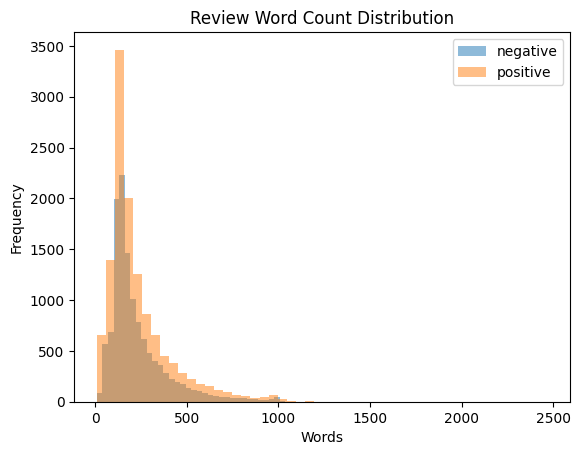

In [45]:
import matplotlib.pyplot as plt

df_lengths = df.copy()
df_lengths['word count'] = df_lengths['review'].apply(lambda x: len(x.split()))

df_lengths.groupby('statement')['word count'].plot(kind='hist', alpha=0.5, legend=True, bins=50)
plt.title("Review Word Count Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()